In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyproj import Transformer, Geod
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pickle
from affine import Affine

In [2]:
data_folder = 'data/'
with open(data_folder + 'arc.pkl', 'rb') as handle:
    ARC = pickle.load(handle)

In [3]:
rift_path = pickle.load( open( 'data/hc-path.pkl', "rb" ) )
riftx,rifty = np.array(rift_path.xy)

transformer_ps2latlon = Transformer.from_crs("EPSG:3031", "EPSG:4326")
transformer_latlon2ps = Transformer.from_crs("EPSG:4326", "EPSG:3031")
geodesic = Geod(ellps='WGS84')

[riftlat,riftlon] = transformer_ps2latlon.transform(riftx,rifty)

<ipython-input-3-cdffedad21ad>:1: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  rift_path = pickle.load( open( 'data/hc-path.pkl', "rb" ) )


# Calculate opening rates

In [4]:
NR_calve = 2021.0 # Set the date early to fit a line through multiple points. Actual date is in february 2021.

# Group data by 'rgt' and 'beam'
grouped = ARC.groupby(['rgt', 'beam'])

# Initialize a list to store results
results = []

# Iterate over each group
for (rgt, beam), group in grouped:
    # Split data into pre-calving and post-calving
    pre_calving = group[group['decimal_year'] < NR_calve]
    post_calving = group[group['decimal_year'] >= NR_calve]
    
    # Analyze both periods
    for period_name, data in zip(['Pre-Calving', 'Post-Calving'], [pre_calving, post_calving]):
        if len(data) >= 2:
            # Prepare data for linear regression
            X = data[['decimal_year']].values
            y = data['actual-non-iceberg-width'].values
            # Perform linear regression
            model = LinearRegression()
            model.fit(X, y)
            slope = model.coef_[0]
            # Calculate mean centroid coordinates
            y_centroid = data['y-centroid'].mean()
            x_centroid = data['x-centroid'].mean()
            # Append results
            results.append({
                'rgt': rgt,
                'beam': beam,
                'Period': period_name,
                'Slope': slope,
                'psy': y_centroid,
                'psx': x_centroid,
                'Dates':X,
                'Confidence': data['confidence'].values,
                'rift-angles':data['rift-angle'].values,
                'rift-angles-change':max(data['rift-angle'].values)-min(data['rift-angle'].values),
                'mean-rift-angle':np.mean(data['rift-angle'].values)
            })
        else:
            # Skip this RGT/beam/period due to insufficient data
            continue

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Separate data by period for plotting
pre_calving_df = results_df[results_df['Period'] == 'Pre-Calving']
post_calving_df = results_df[results_df['Period'] == 'Post-Calving']


# Load landsat

In [10]:
# Load the .npz file
loaded_data = np.load(f'data/LC08_L1GT_184113_184114_20200220_mosaic.npz')

# Assuming the array was saved as 'arr_0' by default, load it as 'norm1'
norm1 = loaded_data['arr_0']

# Load the .npz file
# loaded_data = np.load(f'data/LC08_L1GT_184113_184114_20210206_mosaic.npz')
loaded_data = np.load(f'data/LC08_L1GT_184113_184114_20211020_mosaic.npz')

# Assuming the array was saved as 'arr_0' by default, load it as 'norm1'
norm2 = loaded_data['arr_0']

# Load the .npz file
loaded_data = np.load(f'data/LC08_L1GT_184113_184114_20211105_mosaic.npz')

# Assuming the array was saved as 'arr_0' by default, load it as 'norm1'
norm3 = loaded_data['arr_0']

# Create the Affine object with the same parameters
transform_info = Affine(30.0, 0.0, -819915.0, 0.0, -30.0, 1635615.0)

# DROP a measurement that is clearly bogus
See the supplemental figure that justifies this.

In [6]:
post_calving_df = post_calving_df[post_calving_df.rgt!=1228]

# Make the plot

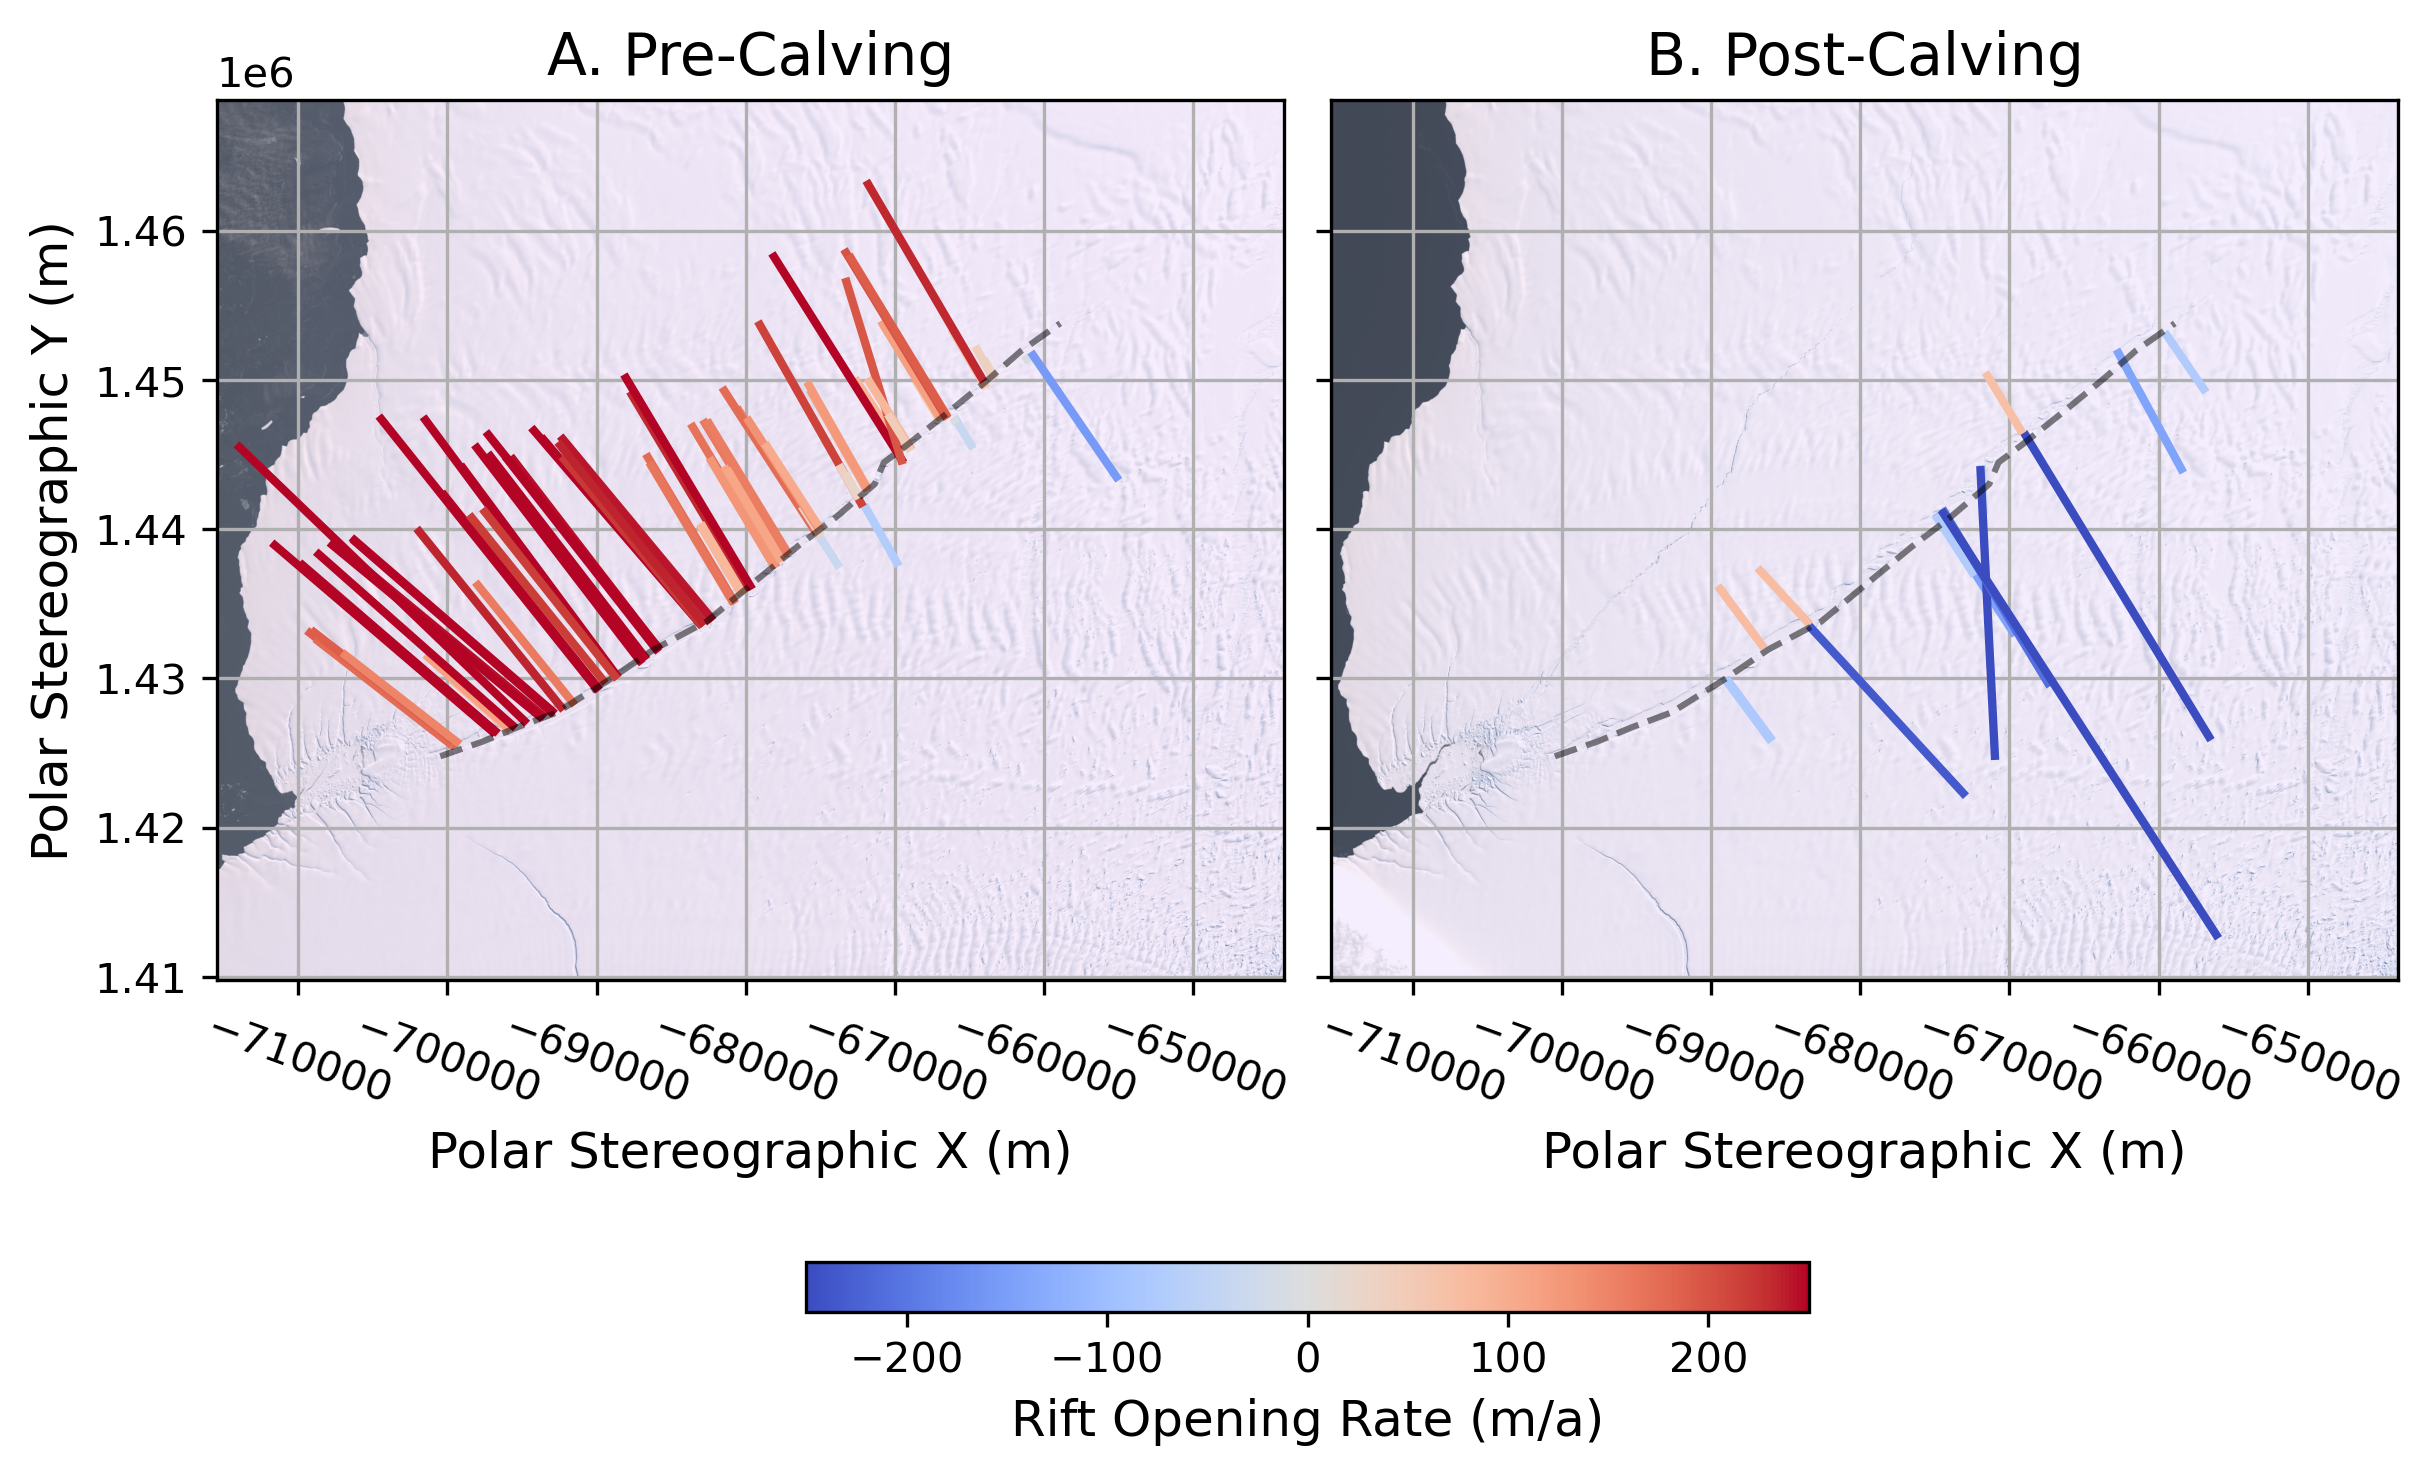

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from rasterio.plot import show

# Set up the plot with constrained_layout
fig, axes = plt.subplots(1,2, dpi=300, constrained_layout=True,figsize=(8,5))
show(norm1.transpose(2, 0, 1), transform=transform_info,ax=axes[0])
show(norm2.transpose(2, 0, 1), transform=transform_info,ax=axes[1])

# Define a diverging colormap
cmap = 'coolwarm'

# Set color scale limits
vmin = -250
vmax = 250
norm = Normalize(vmin=vmin, vmax=vmax)

# Create a ScalarMappable for the colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable

# Prepare the data for plotting
# Combine all psx and psy to calculate limits
all_psx = np.concatenate([pre_calving_df['psx'], post_calving_df['psx']])
all_psy = np.concatenate([pre_calving_df['psy'], post_calving_df['psy']])

psx_min, psx_max = all_psx.min(), all_psx.max()
psy_min, psy_max = all_psy.min(), all_psy.max()

# Add padding to the axes limits
psx_padding = (psx_max - psx_min) * 0.1
psy_padding = (psy_max - psy_min) * 0.1

psx_lim = (psx_min - psx_padding, psx_max + psx_padding)
psy_lim = (psy_min - psy_padding, psy_max + psy_padding)

# Compute scale factor for line lengths
psy_range = psy_lim[1] - psy_lim[0]
max_line_length = psy_range * 0.1  # Max line length is 10% of psy range
slope_range = vmax - vmin  # Should be 2000
scale_factor = max_line_length / slope_range * 10

# Function to plot vertical lines
def plot_opening_lines(ax, df, title):
    x = df['psx'].values
    y = df['psy'].values
    slopes = df['Slope'].values

    # Compute line lengths
    line_lengths = slopes * scale_factor

    factor = 45 # due to conversion from latlon?
    
    # Get the rift angles and compute orthogonal angles in radians
    angle_degrees = df['mean-rift-angle'].to_numpy() + 90 - factor  # Orthogonal to rift axis
    angle_radians = np.deg2rad(angle_degrees)

    # Compute delta_x and delta_y for the line segments
    delta_x = line_lengths * np.cos(angle_radians)
    delta_y = line_lengths * np.sin(angle_radians)

    # Create line segments
    segments = [
        [[xi, yi], [xi + dxi, yi + dyi]]
        for xi, yi, dxi, dyi in zip(x, y, delta_x, delta_y)
    ]

    # Create LineCollection
    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=2)
    lc.set_array(slopes)

    # Add LineCollection to axes
    ax.add_collection(lc)

    # Plot the rift line (assuming riftx and rifty are defined)
    ax.plot(riftx, rifty, '--k',alpha=0.5)

    # Set axes properties
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Polar Stereographic X (m)', fontsize=12)
    ax.set_ylabel('Polar Stereographic Y (m)', fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.set_xlim(psx_lim)
    ax.set_ylim(psy_lim)

    # Adjust font sizes for ticks
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='x', rotation=-20)
    
    image_pad = 15e3
    ax.set_xlim((np.min(riftx)-image_pad,np.max(riftx)+image_pad))
    ax.set_ylim((np.min(rifty)-image_pad,np.max(rifty)+image_pad))

# Plot Pre-Calving data
plot_opening_lines(axes[0], pre_calving_df, 'A. Pre-Calving')

# Plot Post-Calving data
plot_opening_lines(axes[1], post_calving_df, 'B. Post-Calving')

# Create a single colorbar for both subplots, horizontally at the bottom
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.08)
cbar.set_label('Rift Opening Rate (m/a)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Set the overall title
# fig.suptitle('Rift Opening Rate', fontsize=16)
axes[1].set_ylabel('')
axes[1].set_yticklabels([])


# Show the plot
plt.show()